In [305]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
from scipy.stats import pareto
import math 
import statistics 
from scipy.integrate import quad
from sklearn import preprocessing
import seaborn as sns

In [221]:
def teta_est(x):
    return n/sum(np.log(x)) + 1

In [222]:
n = 100
teta = 5

In [235]:
x = pareto.rvs(b=teta-1, size=n)

In [236]:
teta_e = teta_est(x)
teta_e

4.855386671772401

# Confidence interval

## Confidence interval for median

In [237]:
med_b1 = 2**(1/(teta_e-1)) - 1.96*2**(1/(teta_e-1))*np.log(2)/((teta_e-1)*n**0.5)
med_b2 = 2**(1/(teta_e-1)) + 1.96*2**(1/(teta_e-1))*np.log(2)/((teta_e-1)*n**0.5)

In [238]:
print(f'interval for median: ({med_b1}, {med_b2}) real median: {statistics.median(x)}')

interval for median: (1.1547832289965891, 1.2391407775671646) real median: 1.1860838545756707


## Asymptotic for theta

In [239]:
as_b1 = teta_e - 1.96*(teta_e - 1)/(n**0.5)
as_b2 = teta_e + 1.96*(teta_e - 1)/(n**0.5)

In [240]:
print(f'interval for theta: ({as_b1}, {as_b2}) real theta: {teta}')

interval for theta: (4.09973088410501, 5.611042459439791) real theta: 5


## Bootstrap 

In [297]:
delta = np.array([])
teta_boot = np.array([])

for i in range(0,1000):
    bootstrap = np.random.choice(x, size = x.shape[0]).round(2) 
    delta = np.append(delta, teta_est(bootstrap) - teta_e)
    teta_boot = np.append(teta_boot, teta_est(bootstrap))
    

delta.sort() 
b1_boot, b2_boot = teta_e - delta[974], teta_e - delta[24] #better if i use 0.974 shape of delta

In [298]:
print(f'bootstrap interval for theta : ({b1_boot}, {b2_boot}) real theta: {teta}')

bootstrap interval for theta : (4.04093624081855, 5.490585850861983) real theta: 5


## Parametric Bootstrap

In [276]:
delta_par = np.array([])

for i in range(50000):
    bootstrap_par = pareto.rvs(b = teta-1, size=n)
    delta_par = np.append(delta_par, teta_est(bootstrap_par) - teta_e)

delta_par.sort() 
b1_boot_par, b2_boot_par = teta_e - delta_par[int(delta_par.shape[0]*0.974)], teta_e - delta_par[int(delta_par.shape[0]*0.024)]

In [277]:
print(f'parametric bootstrap interval for theta : ({b1_boot_par}, {b2_boot_par}) real theta: {teta}')

parametric bootstrap interval for theta : (3.799677100360271, 5.398924633436909) real theta: 5


## Bayes interval

In [245]:
import decimal
decimal.getcontext().prec = 100

In [246]:
def integrand(tet, x_prod, n):
    return ((decimal.Decimal(tet - 1))**decimal.Decimal(n))*np.exp(decimal.Decimal(1-tet))/decimal.Decimal(decimal.Decimal(x_prod)**decimal.Decimal(tet))

In [247]:
x_prod = x.prod()
res = quad(integrand, 1, np.inf, args=(decimal.Decimal(x_prod), decimal.Decimal(n)))

In [252]:
c = 1/res[0]
c 

0.005768745730925612

In [255]:
def integrand_с(tet, x_prod, n, c):
    return decimal.Decimal(c)*((decimal.Decimal(tet - 1))**decimal.Decimal(n))*np.exp(decimal.Decimal(1-tet))/decimal.Decimal(decimal.Decimal(x_prod)**decimal.Decimal(tet))

In [269]:
%%time

b1_bay = 0
b2_bay = teta*10

for y in np.linspace(3.5, 6, num = 1000):
    res_low = quad(integrand_с, 1, y, args=(decimal.Decimal(x_prod), decimal.Decimal(n), decimal.Decimal(c)))
    res_high = quad(integrand_с, y, np.inf, args=(decimal.Decimal(x_prod), decimal.Decimal(n), decimal.Decimal(c)))
    if abs(res_high[0] - 0.025) < 0.001 and y < b2_bay :
        b2_bay = y
    if abs(res_low[0] - 0.025) < 0.001:
        b1_bay = y
b1_bay, b2_bay

CPU times: total: 1min 12s
Wall time: 1min 13s


(4.058058058058058, 5.50950950950951)

In [ ]:
teta

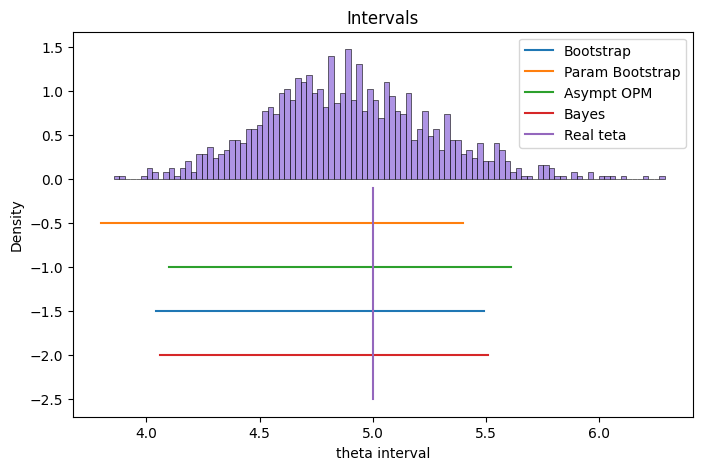

In [331]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot([b1_boot, b2_boot], [-1.5, -1.5], label = 'Bootstrap')
ax.plot([b1_boot_par, b2_boot_par], [-0.5, -0.5], label = 'Param Bootstrap')
ax.plot([as_b1, as_b2], [-1, -1], label = 'Asympt OPM')

ax.plot([b1_bay, b2_bay], [-2, -2], label = 'Bayes')
ax.plot([teta, teta], [-2.5,-0.1], label = 'Real teta')

sns.histplot(teta_boot, ax = ax, bins = n, color = 'MediumPurple', stat = 'density')

ax.set_title('Intervals')    

ax.set_xlabel('theta interval')

ax.legend(loc = 'best')